In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

pd.set_option('display.max_rows',70)
display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

In [ ]:
inputFile = 'collected-data.csv'

In [ ]:
df = pd.read_csv(inputFile)
df

,timestamp,sensor_type,sensor_name,value,accuracy
0,1620723880333,-1,INDOOR,1.0,NaN
1,1620723880364,-1,MONITORING,1.0,NaN
2,1620723873432,5,TMD3725_Light Ambient Light Sensor Non-wakeup,15.0,3.0
3,1620723873265,8,TMD3725_Proximity Proximity Sensor Wakeup,5.0,3.0
4,1620723882262,-1,GPS_SATELLITES,17.0,NaN
...,...,...,...,...,...
2403,1620733476294,5,TMD3725_Light Ambient Light Sensor Non-wakeup,8.0,3.0
2404,1620733477129,8,TMD3725_Proximity Proximity Sensor Wakeup,5.0,3.0
2405,1620733477434,5,TMD3725_Light Ambient Light Sensor Non-wakeup,2.0,3.0
2406,1620733480731,5,TMD3725_Light Ambient Light Sensor Non-wakeup,2.0,3.0


In [ ]:
sensor_type_dict = {
    'MONITORING':-1,
    'INDOOR':-2,
    'GPS_SATELLITES':-3,
    'GPS_FIX_SATELLITES':-4,
    'GPS_FIX':-5,
    'DETECTED_ACTIVITY':-6,
    'WIFI_ACCESS_POINTS':-7,
    'BLUETOOTH_DEVICES':-8
}

for index,row in df.iterrows():
    if  df.loc[index,'sensor_type'] == -1:
        df.loc[index,'sensor_type'] = sensor_type_dict[ row['sensor_name']]

In [ ]:
df_wide = df.pivot_table(index=['timestamp'], columns='sensor_name', values='value')


last_seen_values = {}
sensor_types = df['sensor_name'].unique()
for sensor_type in sensor_types:
    last_seen_values[sensor_type] = float('nan')

for index,row in df_wide.iterrows():
    if row['MONITORING'] == 0:
        for sensor_type in sensor_types:
            last_seen_values[sensor_type] = float('nan')
    else:        
        for sensor_type in sensor_types:
            if math.isnan(row[sensor_type]):
                row[sensor_type] = last_seen_values[sensor_type]
            last_seen_values[sensor_type] = row[sensor_type] 

for index,row in df_wide.iterrows():
    containsNaN = 0.0
    for sensor_type in sensor_types:
        if math.isnan(row[sensor_type]):
            containsNaN = 1.0
            break
    df_wide.loc[index,'containsNaN'] = containsNaN

df_wide = df_wide[(df_wide['MONITORING'] == 1.0) & (df_wide['containsNaN'] == 0.0)] 
del df_wide['containsNaN']

proximity_name = ""
light_name = ""
for sensor_type in sensor_types:
    if 'proximity' in sensor_type.lower():
        proximity_name = sensor_type
        break
    if 'light' in sensor_type.lower():
        light_name = sensor_type
        
df_wide.loc[(df_wide[proximity_name] != 0.0),proximity_name] = 1

Detected_Activity_List = {
  0.0 : "IN_VEHICLE",
  1.0 : "ON_BICYCLE",
  2.0 : "ON_FOOT",
  3.0 : "STILL",
  4.0 : "UNKOWN",
  5.0 : "TILTING",
  7.0 : "WALKING",
  8.0 : "RUNNING"
}

for key in Detected_Activity_List.keys(): 
  df_wide[Detected_Activity_List[key]] = df_wide['DETECTED_ACTIVITY'] == key

df_wide.sort_values(['timestamp'], inplace=True)
target = df_wide.loc[:,'INDOOR']
del df_wide['INDOOR']
del df_wide['GPS_FIX']
del df_wide['MONITORING']
del df_wide['DETECTED_ACTIVITY']

cols = [sensor_type for sensor_type in df_wide.columns.to_list() if sensor_type != proximity_name]
cols.append(proximity_name)
df_wide = df_wide[cols].replace(True,1.0).replace(False,0.0)
df_wide.to_csv('preprocessed_data.csv')
target.to_numpy()
df_wide

sensor_name,BLUETOOTH_DEVICES,GPS_FIX_SATELLITES,GPS_SATELLITES,TMD3725_Light Ambient Light Sensor Non-wakeup,WIFI_ACCESS_POINTS,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,UNKOWN,TILTING,WALKING,RUNNING,TMD3725_Proximity Proximity Sensor Wakeup
timestamp,,,,,,,,,,,,,,
1620724298381,1.0,0.0,35.0,7.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1620724299464,1.0,0.0,35.0,7.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1620724300115,1.0,0.0,35.0,7.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1620724300588,1.0,0.0,35.0,7.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1620724300600,2.0,0.0,35.0,7.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620733475300,0.0,0.0,39.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1620733476294,0.0,0.0,39.0,8.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1620733477129,0.0,0.0,39.0,8.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_wide.to_numpy(), target, test_size=0.33) 
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(1551, 14) (765, 14) (1551,) (765,)


In [ ]:
D = X_train.shape[1]
X_train

array([[ 3.,  0., 17., ...,  0.,  0.,  1.],
       [ 2.,  0., 17., ...,  0.,  0.,  1.],
       [ 0.,  0., 37., ...,  0.,  0.,  1.],
       ...,
       [ 1.,  0., 36., ...,  0.,  0.,  1.],
       [ 0.,  0., 36., ...,  0.,  0.,  1.],
       [ 1.,  0., 36., ...,  0.,  0.,  1.]])

In [ ]:
# Now all the fun Tensorflow stuff
# Build the model

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.LayerNormalization(axis=-1),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])

numpy_input = K.Input(shape=(10,), name="numpy_input")

# Alternatively, you can do:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(1, input_shape=(D,), activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)


# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/200
49/49 [==============================] - 1s 7ms/step - loss: 0.6913 - accuracy: 0.5389 - val_loss: 0.6546 - val_accuracy: 0.5908
Epoch 2/200
49/49 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.5752 - val_loss: 0.6273 - val_accuracy: 0.6170
Epoch 3/200
49/49 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.5994 - val_loss: 0.6010 - val_accuracy: 0.6444
Epoch 4/200
49/49 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6376 - val_loss: 0.5759 - val_accuracy: 0.7059
Epoch 5/200
49/49 [==============================] - 0s 3ms/step - loss: 0.5793 - accuracy: 0.6779 - val_loss: 0.5527 - val_accuracy: 0.7333
Epoch 6/200
49/49 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.6983 - val_loss: 0.5306 - val_accuracy: 0.7725
Epoch 7/200
49/49 [==============================] - 0s 3ms/step - loss: 0.5323 - accuracy: 0.7841 - val_loss: 0.5097 - val_accuracy: 0.8379
Epoch 8/200
4

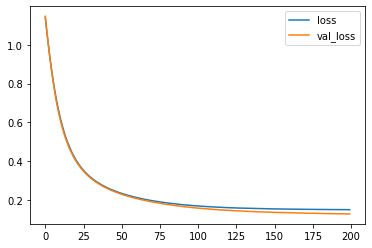

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

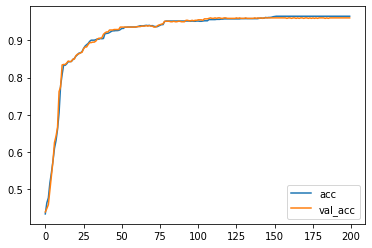

In [ ]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for z in zip(df_wide.columns.values,model.layers[0].get_weights()[0]):
  print(z)


('BLUETOOTH_DEVICES', array([1.5769815], dtype=float32))
('GPS_FIX_SATELLITES', array([-0.5805946], dtype=float32))
('GPS_SATELLITES', array([-1.3195285], dtype=float32))
('TMD3725_Light Ambient Light Sensor Non-wakeup', array([-1.757152], dtype=float32))
('TMD3725_Proximity Proximity Sensor Wakeup', array([0.2236675], dtype=float32))
('WIFI_ACCESS_POINTS', array([2.7982395], dtype=float32))
('IN_VEHICLE', array([-0.42295727], dtype=float32))
('ON_BICYCLE', array([-0.02433211], dtype=float32))
('ON_FOOT', array([-2.6682303], dtype=float32))
('STILL', array([1.1899261], dtype=float32))
('UNKOWN', array([0.13014506], dtype=float32))
('TILTING', array([-0.1099721], dtype=float32))
('WALKING', array([0.30828434], dtype=float32))
('RUNNING', array([0.6284711], dtype=float32))
